# Plot Only

This notebook loads the data generated by the "PAPER Finding Params non neg ODE example" notebook.

In [2]:
from scipy.stats import norm
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

#synth_filename = 'synthetic_ODE_example.pkl'
synth_filename = 'synthetic_ODE_example_1.pkl'

#record_filename = 'recordODEfindparams_u_20.pkl'
record_filename = 'recordODEfindparams_u_28_seed=1.pkl'

[ds, X, Y, sourceGT, concTrain, boundary, m] = pickle.load(open(synth_filename,'rb'))
record = pickle.load(open(record_filename,'rb'))

In [3]:
X[1::2].shape

(15, 2)

In [4]:
record.keys()

dict_keys([0.05011872336272722, 0.10011917018024433, 0.20000206639412044, 0.39953214244489604, 0.7981214180660148, 1.5943593275816654, 3.1849560830059143, 6.362395901093876, 12.709777010190866, 25.38955987020603, 0.06312078826524968, 0.126092616056927, 0.2518876627026026, 0.5031808888248899, 1.0051743073162827, 2.007976476309271, 4.011214274046022, 8.012962373884095, 16.007014738835537, 31.97625408605277, 0.07949591777091264, 0.15880423095253432, 0.317233695459685, 0.6337187424501811, 1.26594195471797, 2.5288963784137133, 5.0518247451390925, 10.091727550975433, 20.159639358255774])

In [35]:
def compute_nlpd(obs_samples,true_vals):
    nlpd = 0
    for idx in range(len(true_vals)):
        ob = np.array(obs_samples)[:,idx]
        nlpd-=norm.logpdf(true_vals[idx],np.mean(ob),np.std(ob))
    return nlpd

temp = []
print('       u  [samps   meanOfSamps    NLPD  ][NN_samps NN_meanOfSamps NN_NLPD]')
for v in sorted(record.keys())[::-1]:
    rec = record[v]
    mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
    row = []
    row.append(v)
    row.append(np.sum((np.array(obs_samples)-Y[1::2])[:-1]**2))
    row.append(np.sum((np.mean(np.array(obs_samples),0)-Y[1::2])[:-1]**2))
    
    row.append(compute_nlpd(obs_samples,Y[1::2][:-1]))
    row.append(np.sum((np.array(obs_nonneg_samples)-Y[1::2])[:-1]**2))
    row.append(np.sum((np.mean(np.array(obs_nonneg_samples),0)-Y[1::2])[:-1]**2))
    row.append(compute_nlpd(obs_nonneg_samples,Y[1::2][:-1]))
    row.append(np.sum((np.std(np.array(obs_samples),0))[:-1]**2))
    row.append(np.sum((np.std(np.array(obs_nonneg_samples),0))[:-1]**2))
    print("%9.2f [%9.1f,%9.1f,%9.1f][%9.1f,%9.1f,%9.1f] [%4.1f %4.1f]" % tuple(row))
    temp.append(row)
#sse_nonneg_samples.append(np.sum((obs-Y[1::2])**2))

       u  [samps   meanOfSamps    NLPD  ][NN_samps NN_meanOfSamps NN_NLPD]
    31.98 [   2409.6,    123.7,  27797.2][   3205.9,    157.2,  71517.6] [ 0.0  0.0]
    25.39 [   1883.9,     97.2,  17020.3][   2866.4,    139.1,  48699.4] [ 0.0  0.0]
    20.16 [   1455.6,     75.5,  10221.8][   2564.6,    123.1,  77501.4] [ 0.1  0.0]
    16.01 [   1121.1,     58.3,   6556.3][   2343.6,    111.4,  18271.4] [ 0.1  0.0]
    12.71 [    871.1,     45.1,   3956.7][   2176.6,    102.5,   3240.2] [ 0.1  0.2]
    10.09 [    704.6,     36.4,   3333.8][   2083.5,     96.0,    783.8] [ 0.1  1.4]
     8.01 [    598.1,     30.6,   2043.5][   2129.1,     92.4,    264.8] [ 0.1  5.2]
     6.36 [    551.1,     27.6,   1712.6][   2296.9,     92.6,    134.2] [ 0.1 10.4]
     5.05 [    528.5,     26.3,   1206.0][   2717.0,     99.6,     98.4] [ 0.1 19.6]
     4.01 [    541.9,     26.5,    981.6][   3101.5,    107.6,     81.6] [ 0.2 25.7]
     3.18 [    545.0,     26.6,    904.1][   3517.6,    121.3,     46.6] [ 

In [6]:
import GPy
np.set_printoptions(precision=2,suppress=True)
def get95CI(vals,neglogprobs):
    ps = np.exp(-neglogprobs+np.min(neglogprobs))
    ps = ps/np.sum(ps)
    #return vals[[np.where(np.cumsum(ps)<0.025)[0][-1],np.where(np.cumsum(ps)>0.975)[0][0]]]
    return vals[[np.where(np.cumsum(ps)<0.16)[0][-1],np.where(np.cumsum(ps)>0.84)[0][0]]]

def get95CIsmoothed(vals,neglogprobs,xs):
    med = np.median(neglogprobs)
    keep = neglogprobs<med*2.5
    med = np.median(neglogprobs[keep])
    m = GPy.models.GPRegression(np.log(vals)[keep,None],neglogprobs[keep,None]-med)
    m.kern.lengthscale=0.5
    m.Gaussian_noise=0.05
    #plt.plot(np.exp(xs),med+m.predict(xs[:,None])[0],'-.')
    return get95CI(np.exp(xs),med+m.predict(xs[:,None])[0]),m,med

In [7]:
chosenUs = [sorted(record.keys())[idx] for idx in [1,6,10,18]] #13

In [8]:
len(record.keys())

29

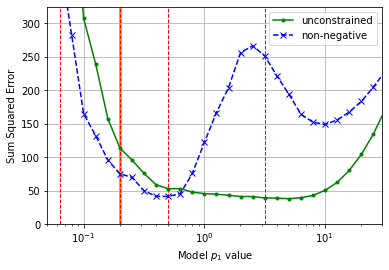

In [56]:
temp = np.array(temp)

num = len(Y[1::2][:-1])
xs = np.linspace(-2.5,2.5,100)
plt.figure()
plt.plot(temp[:,0],temp[:,1]/num,'.-g',label='unconstrained')
plt.plot(temp[:,0],temp[:,4]/num,'x--b',label='non-negative')
plt.ylim([0,325])
plt.vlines(0.2,0,10000,color='orange',lw=3)#label='True $p_1$'
plt.vlines(chosenUs,0,1000,'red',linestyles='dashed',lw=1)

plt.xscale('log')
plt.xlim([0.05,30])
plt.xlabel('Model $p_1$ value')
plt.ylabel('Sum Squared Error');
#plt.vlines(get95CI(temp[:,0],temp[:,1]/200),0,10000,'g')
#plt.vlines(get95CI(temp[:,0],temp[:,4]/200),0,10000,'b')
#CI = get95CI(temp[:,0],temp[:,1]/200); plt.hlines(900,CI[0],CI[1],'g')
#CI = get95CI(temp[:,0],temp[:,4]/200); plt.hlines(800,CI[0],CI[1],'b')
#CIa,ma,meda = get95CI(temp[:,0],temp[:,2]/(2*num),xs); 
#plt.hlines(1.5,CIa[0],CIa[1],'g')#,label='95% CI')
#CIb,mb,medb = get95CI(temp[:,0],temp[:,5]/(2*num),xs); 
#plt.hlines(1.4,CIb[0],CIb[1],'b')#,label='95% CI')
#plt.plot(np.exp(xs),20*(meda+(ma.predict(xs[:,None])[0])),'.')
#plt.plot(np.exp(xs),20*(medb+(mb.predict(xs[:,None])[0])),'.')
plt.legend()#loc='upper center')
plt.savefig('paper_sse_ODE_constraint.pdf')
plt.grid()

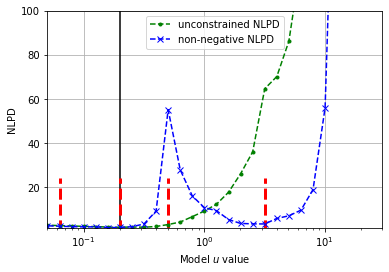

In [44]:
temp = np.array(temp)

num = len(Y[1::2][:-1])
xs = np.linspace(-2.5,2.5,100)
plt.figure()
plt.plot(temp[:,0],temp[:,3]/num,'.--g',label='unconstrained NLPD')
plt.plot(temp[:,0],temp[:,6]/num,'--xb',label='non-negative NLPD')
plt.ylim([1.5,100])
plt.vlines(0.2,0,10000,color='black')#label='True $p_1$'
plt.vlines(chosenUs,0,24,'red',linestyles='dashed',lw=3)

plt.xscale('log')
plt.xlim([0.05,30])
plt.xlabel('Model $u$ value')
plt.ylabel('NLPD');
#plt.vlines(get95CI(temp[:,0],temp[:,1]/200),0,10000,'g')
#plt.vlines(get95CI(temp[:,0],temp[:,4]/200),0,10000,'b')
#CI = get95CI(temp[:,0],temp[:,1]/200); plt.hlines(900,CI[0],CI[1],'g')
#CI = get95CI(temp[:,0],temp[:,4]/200); plt.hlines(800,CI[0],CI[1],'b')
#CIa,ma,meda = get95CIsmoothed(temp[:,0],temp[:,3]/(2*num),xs); 
#plt.hlines(2.5,CIa[0],CIa[1],'g')#,label='95% CI')
#CIb,mb,medb = get95CIsmoothed(temp[:,0],temp[:,6]/(2*num),xs); 
#plt.hlines(3.0,CIb[0],CIb[1],'b')#,label='95% CI')
#plt.plot(np.exp(xs),20*(meda+(ma.predict(xs[:,None])[0])),'.')
#plt.plot(np.exp(xs),20*(medb+(mb.predict(xs[:,None])[0])),'.')
plt.legend(loc='upper center')
plt.savefig('paper_nlpd_ODE_constraint.pdf')
plt.grid()

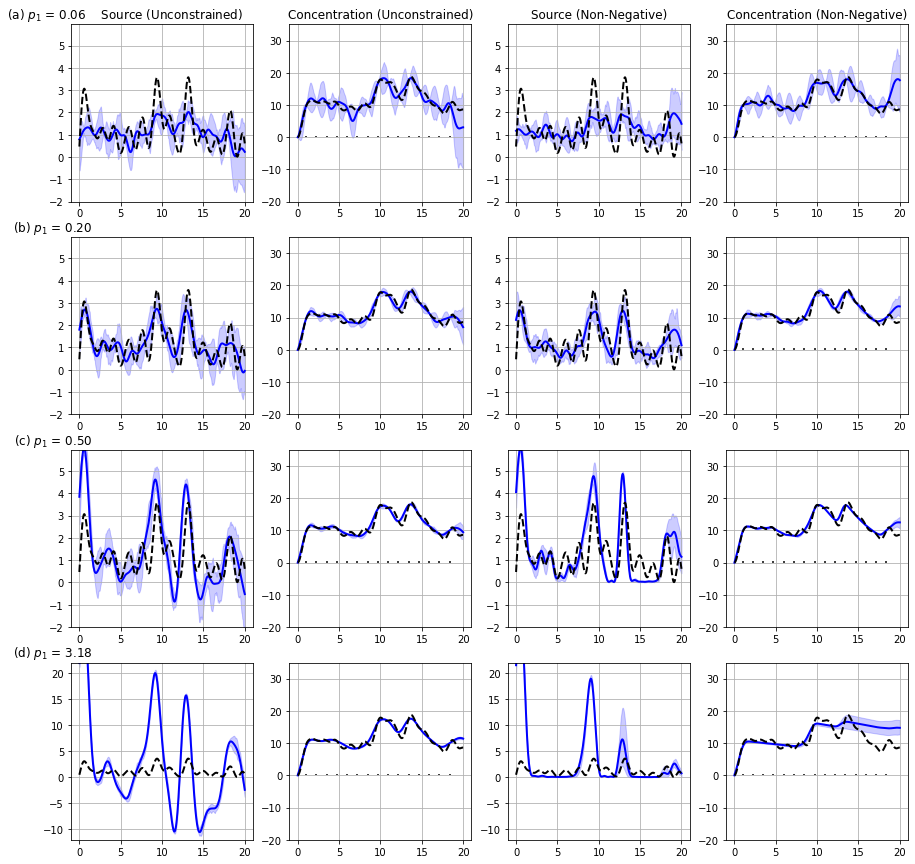

In [55]:
plt.figure(figsize=[15,15])

labels = ['a','b','c','d']
for row,v in enumerate(chosenUs):
    
    rec = record[v]
    #plt.figure(figsize=[10,4])
    mTest,regressors,meanZ,covZ,concInferred_samples,sourceInferred_samples,sse_samples,obs_samples,concInferred_nonneg_samples,sourceInferred_nonneg_samples,sse_nonneg_samples,obs_nonneg_samples = rec
    
    for idx, (s_samps, c_samps) in enumerate(zip([sourceInferred_samples,sourceInferred_nonneg_samples],[concInferred_samples,concInferred_nonneg_samples])):
        plt.subplot(4,4,(1+idx*2)+row*4)
        plt.plot(ds.m.coords[0,:],np.mean(s_samps,0),'b-',lw=2,label='no constr.')
        #plt.plot(ds.m.coords[0,:],np.array(s_samps).T,'b-',alpha=0.15)
        #cis = np.percentile(s_samps,[2.5,97.5],axis=0)
        cis = np.percentile(s_samps,[16,84],axis=0)
        plt.fill_between(ds.m.coords[0,:],cis[0],cis[1],color='blue',alpha=0.2)
        #plt.fill_between(ds.m.coords[0,:],np.min(np.array(s_samps).T,1),np.max(np.array(s_samps).T,1),color='blue',alpha=0.2)
        plt.plot(ds.m.coords[0,:],sourceGT,'k--',lw=2,label='true')
        if row<3:
            plt.ylim([-2,5.95])
        else:
            plt.ylim([-12,22])
            #plt.text(0,-11,'y-axis scale changed')
        
            
        plt.grid()
        #plt.legend()
     
        if (row==0):
            if idx==0:
                plt.title('(%s) $p_1$ = %0.2f    Source (Unconstrained)                    ' % (labels[row],v))
            else:
                plt.title('Source (Non-Negative)')
        else:
            if idx==0:
                plt.title('(%s) $p_1$ = %0.2f                                                          ' % (labels[row],v))
        ####
        
        plt.subplot(4,4,(2+idx*2)+row*4)
        plt.plot(ds.m.coords[0,:],np.mean(c_samps,0),'b-',lw=2,label='no constr.')
        #plt.plot(ds.m.coords[0,:],np.array(c_samps).T,'b-',alpha=0.15)
        cis = np.percentile(c_samps,[16,84],axis=0)
        plt.fill_between(ds.m.coords[0,:],cis[0],cis[1],color='blue',alpha=0.2)
        plt.plot(ds.m.coords[0,:],concTrain,'k--',lw=2,label='true')
        
        plt.grid()
        #plt.legend()
        plt.ylim([-20,35])
        #plt.title("u = %0.4f" % v)
        if row==0: 
            if idx==0:
                plt.title('Concentration (Unconstrained)')
            else:
                plt.title('Concentration (Non-Negative)')
        plt.vlines(X[::2,0],0,0.5)
plt.savefig('paper_examples_ODE_constraint.pdf')


#-p_2 u'' + p_1 u' + p_0 u = f
#MSE